<a href="https://colab.research.google.com/github/TheJoys2019/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/Artin%20Sinani%20-%20LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [0]:
import random
random.seed(42)
#dir(random)  # Reminding ourselves what we can do here

In [4]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [5]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=150.42273427770718, mobile=False), User(purchased=True, time_on_site=284.06235530493245, mobile=True), User(purchased=True, time_on_site=140.37976895454653, mobile=True), User(purchased=True, time_on_site=49.206452507812216, mobile=True), User(purchased=False, time_on_site=167.81563803588924, mobile=True), User(purchased=False, time_on_site=20.484876517641524, mobile=True), User(purchased=False, time_on_site=167.3540069049869, mobile=True), User(purchased=False, time_on_site=447.75054592529114, mobile=False), User(purchased=True, time_on_site=57.93525538719398, mobile=True), User(purchased=True, time_on_site=292.6494305470663, mobile=True)]


In [6]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,150.422734,False
1,True,284.062355,True
2,True,140.379769,True
3,True,49.206453,True
4,False,167.815638,True


In [7]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.789338167851291,5.836487686604824,7.267690340465448,7.280322437947023,7.733814701629437,7.772242279186957,7.994578759409748,8.373541587279558,9.106003254765849,9.38379653305911,...,582.5363605031145,582.9362427920347,588.8783154469735,590.65747470592,593.8187768755912,597.1381204299279,597.7116143416571,598.547187832115,599.088120104121,599.5766563635087
purchased,,,,,,,,,,,,,,,,,,,,,
False,1,1,0,1,1,1,1,1,1,1,...,0,1,1,0,1,1,1,1,1,1
True,0,0,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0


In [8]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(5.196, 124.547]","(124.547, 243.304]","(243.304, 362.062]","(362.062, 480.819]","(480.819, 599.577]"
purchased,,,,,
False,227,238,111,23,37
True,106,133,84,20,21


In [9]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(5.196, 124.547]","(124.547, 243.304]","(243.304, 362.062]","(362.062, 480.819]","(480.819, 599.577]"
purchased,,,,,
False,0.681682,0.641509,0.569231,0.534884,0.637931
True,0.318318,0.358491,0.430769,0.465116,0.362069


In [10]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.704,0.613333
True,0.296,0.386667


In [11]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

pd.crosstab(user_data['mobile'],[user_data['purchased'], time_bins], 
            rownames=['Device'], colnames=['purchased','time on site'])

purchased               False                                        \
time on site (5.196, 124.547] (124.547, 243.304] (243.304, 362.062]   
Device                                                                
False                      37                 43                 36   
True                      190                195                 75   

purchased                                                     True   \
time on site (362.062, 480.819] (480.819, 599.577] (5.196, 124.547]   
Device                                                                
False                        23                 37                4   
True                          0                  0              102   

purchased                                                              \
time on site (124.547, 243.304] (243.304, 362.062] (362.062, 480.819]   
Device                                                                  
False                        11                 18                 20   
True                        122                 66                  0   

purchased                        
time on site (480.819, 599.577]  
Device                           
False                        21  
True                          0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff552f74f98>,
      dtype=object)

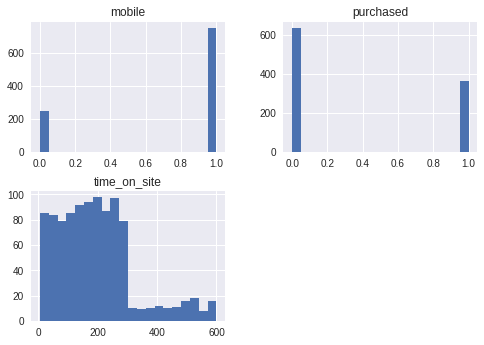

In [12]:
#user_data.plot.bar(x='mobile', y=time_bins)

user_data.hist(bins=20)

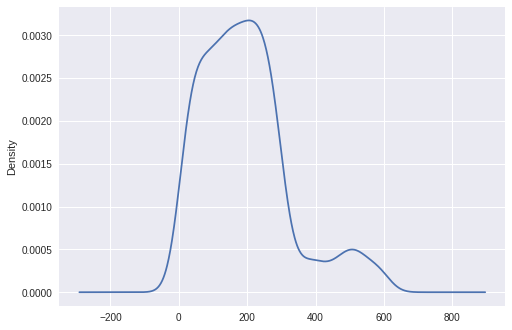

In [13]:
user_data['time_on_site'].plot.density()

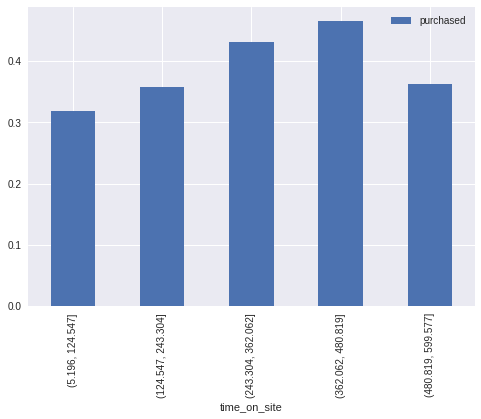

In [14]:
pd.pivot_table(user_data, values='purchased', index=time_bins).plot.bar()

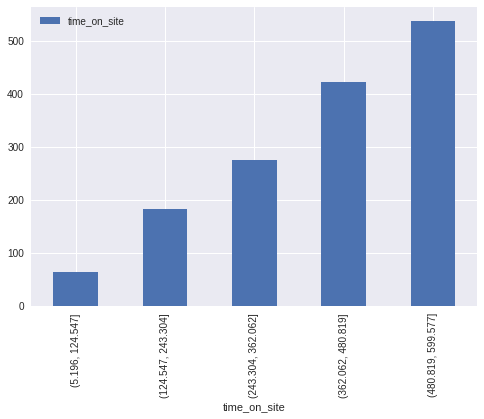

In [15]:
pd.pivot_table(user_data, values='time_on_site', index=time_bins).plot.bar()

In [17]:

ct = pd.crosstab(time_bins, [user_data['purchased'], user_data['mobile']], normalize='columns')
print(type(ct))
ct

<class 'pandas.core.frame.DataFrame'>


purchased              False               True           
mobile                 False     True      False     True 
time_on_site                                              
(5.196, 124.547]    0.210227  0.413043  0.054054  0.351724
(124.547, 243.304]  0.244318  0.423913  0.148649  0.420690
(243.304, 362.062]  0.204545  0.163043  0.243243  0.227586
(362.062, 480.819]  0.130682  0.000000  0.270270  0.000000
(480.819, 599.577]  0.210227  0.000000  0.283784  0.000000

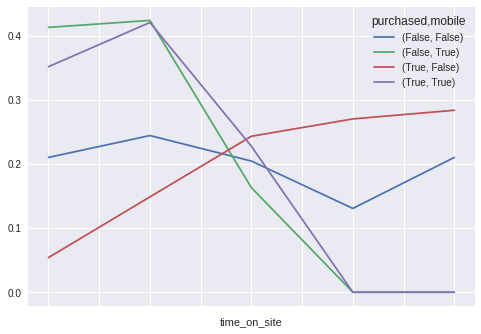

In [18]:
ct.plot()

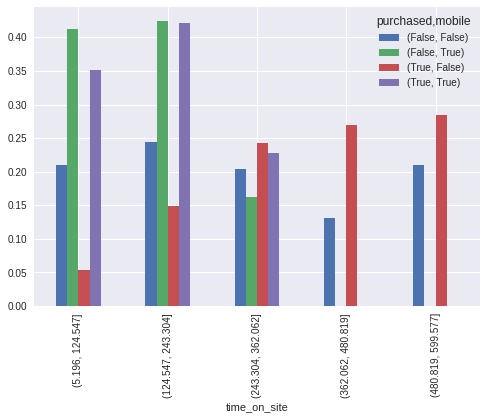

In [19]:
ct.plot(kind='bar')

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [31]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself

import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
import seaborn as sns

peeps = pd.read_csv('https://raw.githubusercontent.com/TheJoys2019/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module4-databackedassertions/persons.csv', index_col=0)

peeps.head()

,age,weight,exercise_time
0,44,118,192
1,41,161,35
2,46,128,220
3,39,216,57
4,28,116,182


In [32]:
peeps.isna().sum()

age              0
weight           0
exercise_time    0
dtype: int64

In [33]:
peeps.describe

<bound method NDFrame.describe of       age  weight  exercise_time
0      44     118            192
1      41     161             35
2      46     128            220
3      39     216             57
4      28     116            182
5      58     103            165
6      55     161            107
7      21     188             37
8      55     216             79
9      50     127            267
10     21     160            228
11     43     102             78
12     73     209             44
13     27     165             48
14     21     169            171
15     36     131            194
16     49     171            191
17     69     172            147
18     18     122            271
19     55     157            111
20     19     218             28
21     34     143             24
22     20     116            267
23     20     159            241
24     32     117            181
25     71     103             21
26     21     164            229
27     79     189             38
28     72

In [34]:
pd.crosstab(peeps['age'], peeps['weight'])

weight,100,101,102,103,104,105,106,107,108,109,...,234,236,237,238,239,240,241,242,244,246
age,,,,,,,,,,,,,,,,,,,,,
18,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
20,0,1,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
21,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22,0,0,0,0,1,0,0,0,1,1,...,0,0,0,0,0,1,0,0,0,0
23,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
24,0,1,0,0,0,0,0,0,1,0,...,1,1,0,0,0,0,0,0,0,0
25,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
26,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [35]:
aw_bins = pd.cut(peeps['weight'], 5)  # 5 equal-sized bins
wa_bins = pd.cut(peeps['age'], 5) # 5 equal-sized bins
wa_aw = pd.crosstab(wa_bins, aw_bins)
wa_aw

weight,"(99.854, 129.2]","(129.2, 158.4]","(158.4, 187.6]","(187.6, 216.8]","(216.8, 246.0]"
age,,,,,
"(17.938, 30.4]",80,86,49,34,7
"(30.4, 42.8]",104,62,49,31,7
"(42.8, 55.2]",78,62,49,26,8
"(55.2, 67.6]",53,71,45,44,9
"(67.6, 80.0]",60,54,66,44,22


In [36]:
pd.crosstab(wa_bins, aw_bins, normalize='columns')

weight,"(99.854, 129.2]","(129.2, 158.4]","(158.4, 187.6]","(187.6, 216.8]","(216.8, 246.0]"
age,,,,,
"(17.938, 30.4]",0.213333,0.256716,0.189922,0.189944,0.132075
"(30.4, 42.8]",0.277333,0.185075,0.189922,0.173184,0.132075
"(42.8, 55.2]",0.208000,0.185075,0.189922,0.145251,0.150943
"(55.2, 67.6]",0.141333,0.211940,0.174419,0.245810,0.169811
"(67.6, 80.0]",0.160000,0.161194,0.255814,0.245810,0.415094


In [37]:
ea_bins = pd.cut(peeps['exercise_time'], 5)
pd.crosstab(wa_bins, ea_bins, normalize='columns')

exercise_time,"(-0.3, 60.0]","(60.0, 120.0]","(120.0, 180.0]","(180.0, 240.0]","(240.0, 300.0]"
age,,,,,
"(17.938, 30.4]",0.187050,0.145570,0.242152,0.317708,0.225131
"(30.4, 42.8]",0.187050,0.174051,0.188341,0.244792,0.298429
"(42.8, 55.2]",0.147482,0.132911,0.174888,0.177083,0.350785
"(55.2, 67.6]",0.165468,0.224684,0.179372,0.213542,0.125654
"(67.6, 80.0]",0.312950,0.322785,0.215247,0.046875,0.000000


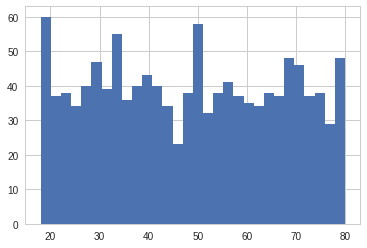

In [38]:
peeps['age'].hist(bins=30)

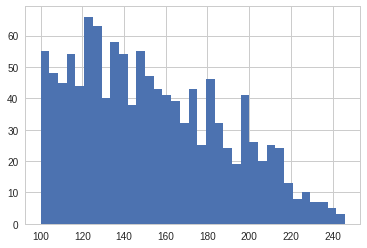

In [39]:
peeps['weight'].hist(bins=35)

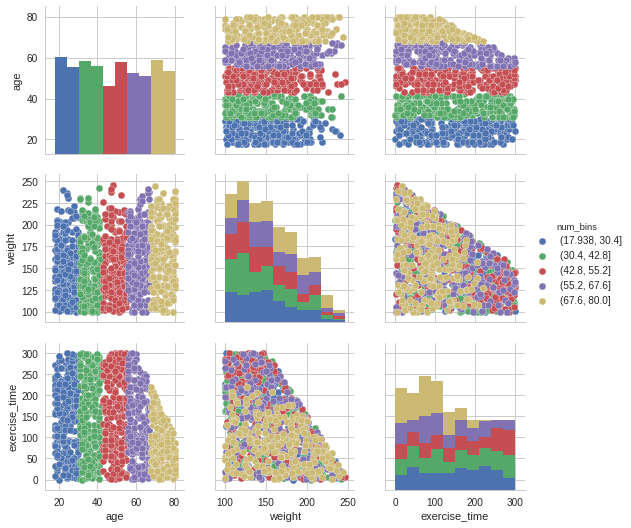

In [40]:
num_bins = pd.cut(peeps['age'], 5)

peeps['num_bins'] = num_bins

sns.pairplot(peeps, hue='num_bins')

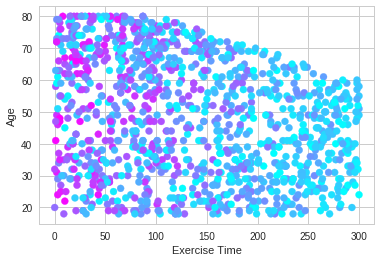

In [41]:
plt.scatter('exercise_time', 'age', c='weight', cmap="cool", data=peeps)
plt.xlabel('Exercise Time')
plt.ylabel('Age')
plt.show()

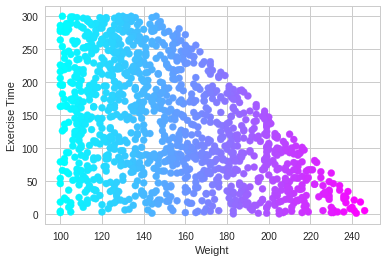

In [28]:
plt.scatter('weight','exercise_time', c='weight', cmap='cool', data=peeps)

plt.xlabel('Weight')
plt.ylabel('Exercise Time')
plt.show()

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
      
      The variable types are all discrete and the dataframe is wide format.
      
2.  What are the relationships between the variables?

      The relationships between the variables clearly shows that the as your weight goes higher, the less time you exercise. This relationship makes complete sense. As the heavier you become, it becomes much harder to exercise, thus you cannot be as active for that long. 

3.  Which relationships are "real", and which spurious?
      Weight vs Exercise Time seems "real" to me because of the relationship described in question 2. 
      
      Spurious? San Antonio Spurs? Greg Popovich? I can't seem to find any variables that seem spurious. 
      
      


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)